In [1]:
!gdown 18O-sElP7syAZkehTbJ-VUtd92WV6FWu5

Downloading...
From (original): https://drive.google.com/uc?id=18O-sElP7syAZkehTbJ-VUtd92WV6FWu5
From (redirected): https://drive.google.com/uc?id=18O-sElP7syAZkehTbJ-VUtd92WV6FWu5&confirm=t&uuid=b6fc753e-e090-4c11-8b40-4226a22e4934
To: /content/prepro_Knee.zip
100% 360M/360M [00:06<00:00, 55.4MB/s]


In [2]:
!unzip /content/prepro_Knee.zip -d /content/knee_prepro

Streaming output truncated to the last 5000 lines.
  inflating: /content/knee_prepro/train/1/9213753R.png  
  inflating: /content/knee_prepro/train/1/9216735R.png  
  inflating: /content/knee_prepro/train/1/9217260R.png  
  inflating: /content/knee_prepro/train/1/9217911R.png  
  inflating: /content/knee_prepro/train/1/9217997L.png  
  inflating: /content/knee_prepro/train/1/9218438L.png  
  inflating: /content/knee_prepro/train/1/9218438R.png  
  inflating: /content/knee_prepro/train/1/9218916R.png  
  inflating: /content/knee_prepro/train/1/9219596L.png  
  inflating: /content/knee_prepro/train/1/9219596R.png  
  inflating: /content/knee_prepro/train/1/9220921R.png  
  inflating: /content/knee_prepro/train/1/9223040L.png  
  inflating: /content/knee_prepro/train/1/9223040R.png  
  inflating: /content/knee_prepro/train/1/9223285R.png  
  inflating: /content/knee_prepro/train/1/9223303R.png  
  inflating: /content/knee_prepro/train/1/9223590L.png  
  inflating: /content/knee_prepro/tra

In [3]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

In [4]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "/content/knee_prepro/new",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 9786 files belonging to 3 classes.
Using 7829 files for training.
Using 1957 files for validation.


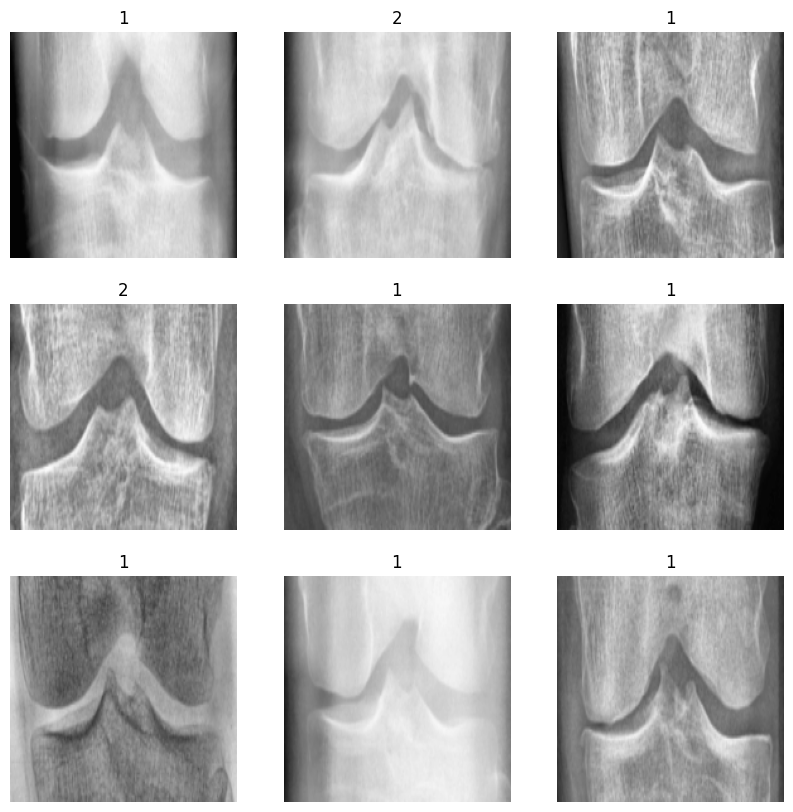

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [6]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images


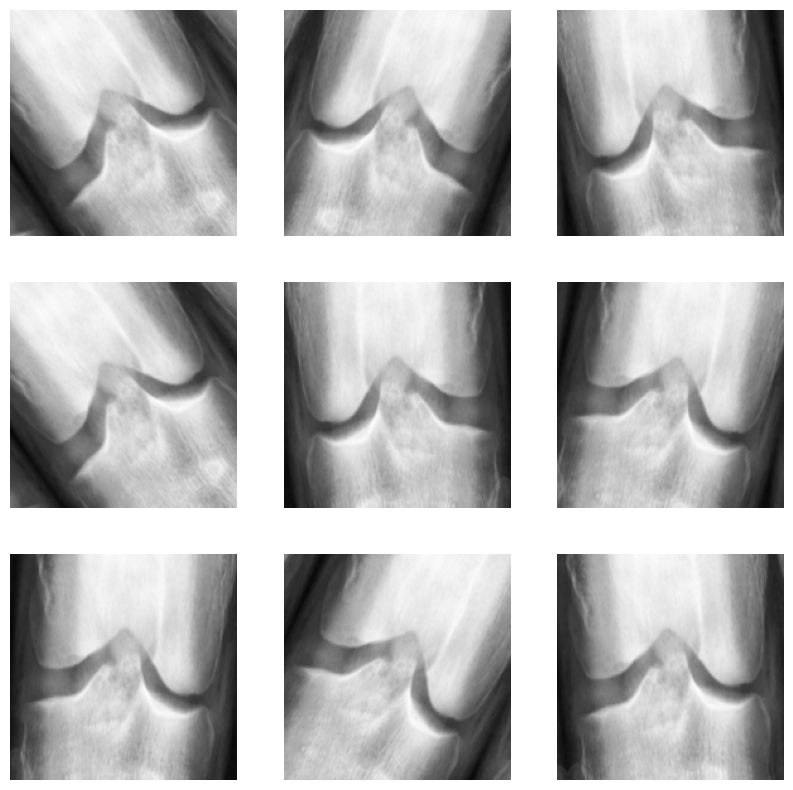

In [7]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [8]:

train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)

train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

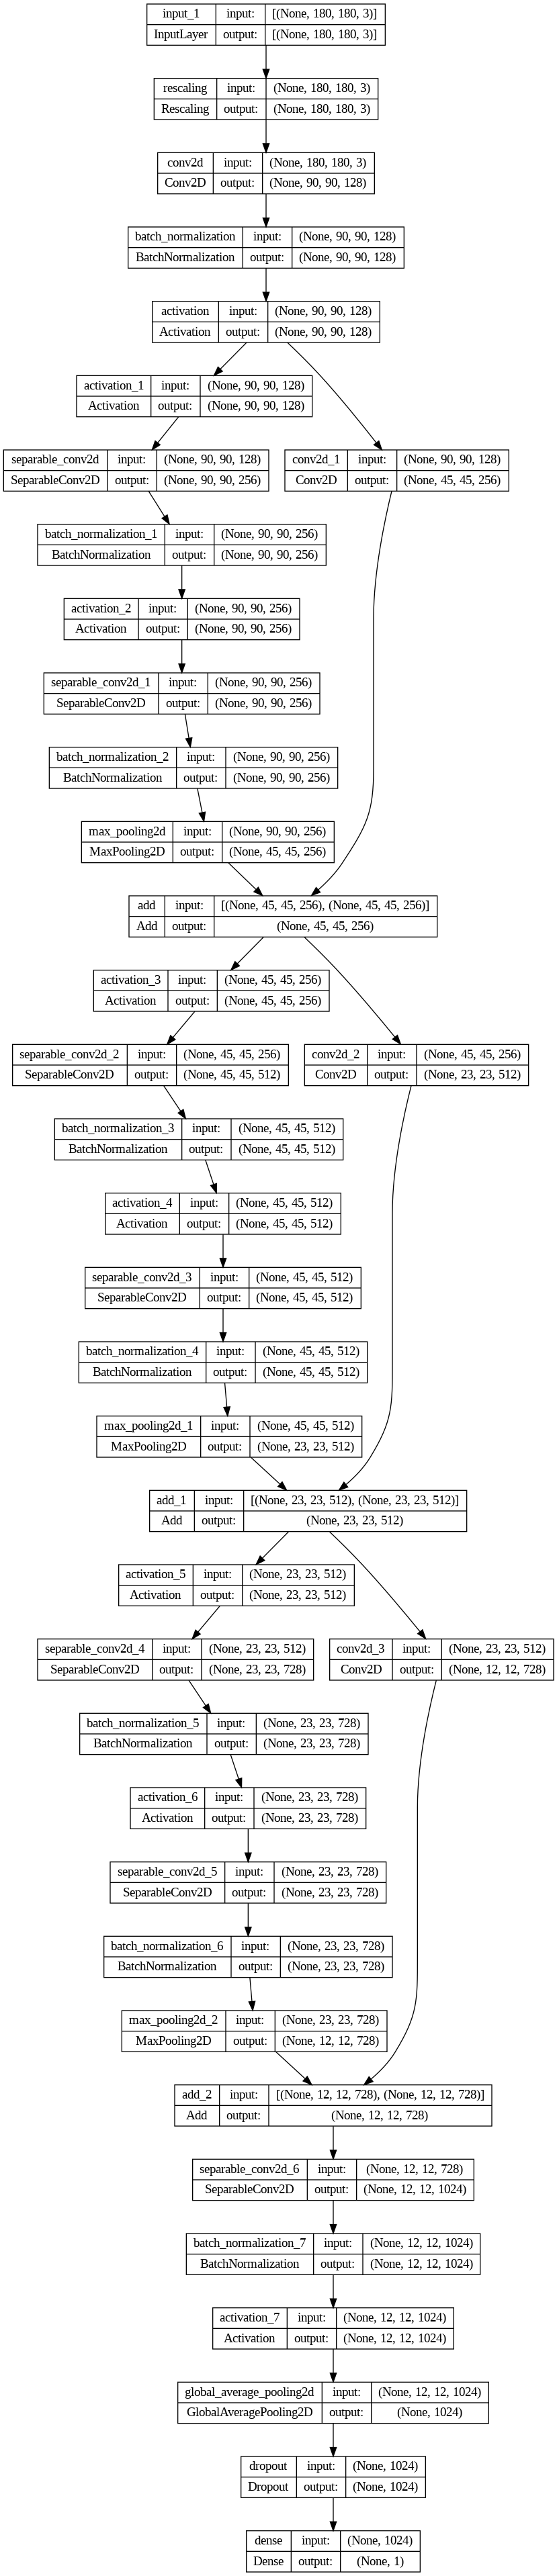

In [9]:

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)


    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)


        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])
        previous_block_activation = x

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)

    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [10]:
epochs = 13

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25
62/62 [==============================] - 128s 2s/step - loss: 0.3037 - acc: 0.7385 - val_loss: 0.6101 - val_acc: 0.1783
Epoch 2/25
62/62 [==============================] - 89s 1s/step - loss: 0.2966 - acc: 0.7472 - val_loss: 0.5403 - val_acc: 0.1783
Epoch 3/25
62/62 [==============================] - 91s 1s/step - loss: 0.2924 - acc: 0.7473 - val_loss: 0.4799 - val_acc: 0.7425
Epoch 4/25
62/62 [==============================] - 89s 1s/step - loss: 0.2890 - acc: 0.7473 - val_loss: 0.4201 - val_acc: 0.7425
Epoch 5/25
62/62 [==============================] - 90s 1s/step - loss: 0.2872 - acc: 0.7473 - val_loss: 0.3879 - val_acc: 0.7425
Epoch 6/25
62/62 [==============================] - 88s 1s/step - loss: 0.2862 - acc: 0.7473 - val_loss: 0.3622 - val_acc: 0.7425
Epoch 7/25
62/62 [==============================] - 91s 1s/step - loss: 0.2865 - acc: 0.7473 - val_loss: 0.3564 - val_acc: 0.7425
Epoch 8/25
62/62 [==============================] - 89s 1s/step - loss: 0.2860 - acc: 0.7

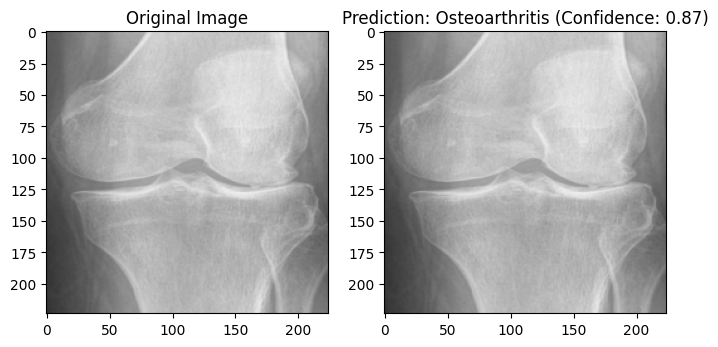

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

# Load the image
img = keras.utils.load_img("/content/knee_prepro/test/4/9048789L.png", target_size=image_size)

# Display the original image
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')

# Convert the image to array
img_array = keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Make predictions
score = float(keras.backend.sigmoid(predictions[0][0]))

# Display the prediction result
plt.subplot(1, 2, 2)
plt.imshow(img)
if score >= 0.5:
    plt.title(f'Prediction: Osteoarthritis (Confidence: {score:.2f})')
else:
    plt.title(f'Prediction: No Osteoarthritis (Confidence: {1-score:.2f})')
plt.show()


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 180, 180, 3), found shape=(32, 224, 3)


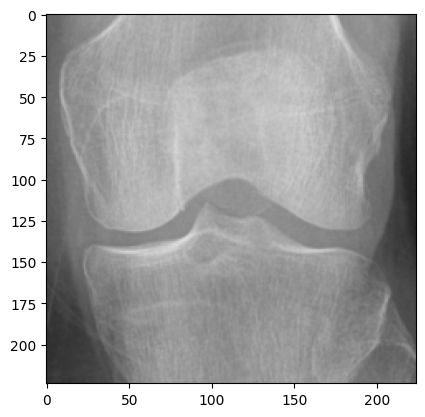